In [2]:
import jiwer

transforms = jiwer.Compose(
    [
        jiwer.RemoveEmptyStrings(),
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.RemovePunctuation(),
        jiwer.ReduceToListOfListOfWords(),
    ]
)

reference = """
Hi, everybody. I've spoken at a lot of events over the years
"""

hypothesis = """
Hi, everybody. I've spoken a lot of events over the pasted years
"""

wer = jiwer.wer(
                reference,
                hypothesis,
                truth_transform=transforms,
                hypothesis_transform=transforms,
            )
print(f"Word Error Rate (WER) :", wer)
print(f"Therefore the accuracy:", 1-wer)

Word Error Rate (WER) : 0.16666666666666666
Therefore the accuracy: 0.8333333333333334


In [3]:
!pip install pytesseract



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import pytesseract

import cv2

def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


img = cv2.imread("tesseract_testy_2.png")

img = get_grayscale(img)
img = thresholding(img)

result = pytesseract.image_to_string(img)
print(result)

Odbiorca:

KRA339M
Sabaly 49
31-416 Krakow
tel = 4 B31



In [5]:
# pytesseract.get_languages()

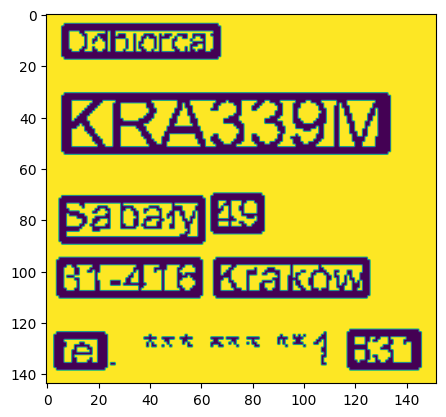

In [6]:
from pytesseract import Output

d = pytesseract.image_to_data(img, output_type=Output.DICT)

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

import matplotlib.pyplot as plt

plt.imshow(img)

In [7]:
# komórka na finalny skrypt 
import os
import numpy as np

# całość poniej była puszczona na colabie, ze względu na błędy modelu kiedy puszczałem go lokalnie
# tak pozyskałem wyniki (results) dla zbiorów treningowego, validacyjnego oraz testowego
# te wyniki uzywam ponizej razem z biblioteką jitter do obliczenia wynikow WER

######################
# from ultralytics import YOLO


# print("loading model")
# model = YOLO("ran_on_colab/weights/best_best.pt")
# print("loaded model")

# path_to_train_im = "ran_on_colab/images/test/"
# path_to_train_info_excel = "data/generated_labels/first_gen_2024-06-24.xlsx"

# files_np = np.array(os.listdir(path_to_train_im))
# file_paths = np.char.add(path_to_train_im, files_np)

# file_paths_short = file_paths[:20]

# results = model(source=file_paths_short.tolist())
######################

In [8]:
import pickle
import io
import torch

# ze wzgledu na roznice maszyn potrzeba otworzyć w specjlany sposob:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

with open("ran_on_colab/results_saved/train/train_results.pkl", "rb") as file:
    loaded_train_results = CPU_Unpickler(file).load()

with open("ran_on_colab/results_saved/test/test_results.pkl", "rb") as file:
    loaded_test_results = CPU_Unpickler(file).load()
    
with open("ran_on_colab/results_saved/val/val_results.pkl", "rb") as file:
    loaded_val_results = CPU_Unpickler(file).load()



In [9]:
import pandas as pd

path_to_train_info_excel = "data/generated_labels/first_gen_2024-06-24.xlsx"
generated_df = pd.read_excel(path_to_train_info_excel)

generated_df.head()

,Unnamed: 0,label_tag,label_type,uwagi,odbiorca,nadawca
0,0,0,dhl_1,Proszę zadzwonić domofonem.,Magdalena Kozak ul. Michałowska 113 03-767 W...,Mateusz Stępień ul. Nawigacyjna 19 60-480 Po...
1,0,1,inpost_3,"Upewnić się, że ktoś odbierze",MORSKI KWIAT ul. Wałuszewska 55 03-005 Warsz...,SŁONECZNA POLANA ul. Obrzańska 86 60-114 Poz...
2,0,2,inpost_3,Zadzwonić na numer kontaktowy,Gabriela Pawlik ul. Mickiewicza Adama 113 81...,Maria Nowak ul. Generała Fiszera Józefa 20 8...
3,0,3,dhl_1,Proszę o delikatne obchodzeni,Mariusz Piekarski ul. Mała 144 15-317 Białys...,Krzysztof Kwiatkowski ul. Brzozowa 125 43-60...
4,0,4,pocztex_1,Proszę dostarczyć na tylną fu,Paulina Łukasik ul. Wierzbowa 64 41-100 Siem...,Joanna Borowska ul. Płońska 48 03-683 Warsza...


In [10]:
generated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  100 non-null    int64 
 1   label_tag   100 non-null    int64 
 2   label_type  100 non-null    object
 3   uwagi       100 non-null    object
 4   odbiorca    100 non-null    object
 5   nadawca     100 non-null    object
dtypes: int64(2), object(4)
memory usage: 4.8+ KB


In [41]:
# development na wynikach walidacyjnych
# TODO: podział skuteczności wedle rodzaju etykiety


class_names_dict = {0:"nadawca",
                    1:"odbiorca",
                    2:"uwagi"}

nadawca_scores = []
odbiorca_scores = []
uwagi_scores = []

nadawca_scores_cer = []
odbiorca_scores_cer = []
uwagi_scores_cer = []

nadawca_scores_mer = []
odbiorca_scores_mer = []
uwagi_scores_mer = []

inpost_wer = []
dhl_wer = []
dpd_wer = []
pocztex_wer = []


for k, result in enumerate(loaded_train_results):
    orig_image = result.orig_img
    fullpath = result.path
    number = int(fullpath.split("_")[-1][:-5]) # zadziała dla train i val, nie dla test
    detected_classes = result.boxes.cls
    detected_boxes = result.boxes
    
    for i, class_detected in enumerate(detected_classes):
        class_int = int(class_detected.numpy())
        [x1, y1, x2, y2] = detected_boxes[i].xyxy.numpy().astype(int)[0]
        fragment = orig_image[y1:y2, x1:x2, :] # działa! 
        
        # #blur
        # img = cv2.blur(fragment, (10,10))
        
        # #sharpen
        # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        # img = cv2.filter2D(img, -1, kernel)
        
        img = get_grayscale(fragment)
        img = cv2.GaussianBlur(img,(5,5),0)
        # img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
        #     cv2.THRESH_BINARY,11,2)
        img = thresholding(img)
        
        #open
        kernel = np.ones((4,4),np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
        
        #close
        kernel = np.ones((4,4),np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        
        
        # stretch_near = cv2.resize(img, (2*(y2-y1), 2*(x2-x1)), 
        #        interpolation = cv2.INTER_LINEAR)

        text_on_fragment = pytesseract.image_to_string(img)
        # print(text_on_fragment)

        text_category = class_names_dict[class_int]
        text_to_decipher = generated_df.iloc[number][text_category]
        label_type = generated_df.iloc[number]['label_type'].split('_')[0]
        # print(text_to_decipher)
        
        wer = jiwer.wer(
                text_to_decipher,
                text_on_fragment,
                truth_transform=transforms,
                hypothesis_transform=transforms,
            )

        cer = jiwer.cer(
                text_to_decipher,
                text_on_fragment,
                truth_transform=transforms,
                hypothesis_transform=transforms,
            )
        
        mer = jiwer.mer(
                text_to_decipher,
                text_on_fragment,
                truth_transform=transforms,
                hypothesis_transform=transforms,
            )
        
        
        if label_type == "inpost":
            inpost_wer.append(wer)
        elif label_type == "dhl":
            dhl_wer.append(wer)
        elif label_type == "pocztex":
            pocztex_wer.append(wer)
        else:
            dpd_wer.append(wer)
        
        if class_int == 0:
            nadawca_scores.append(wer)
            nadawca_scores_cer.append(cer)
            nadawca_scores_mer.append(mer)
        elif class_int == 1:
            odbiorca_scores.append(wer)
            odbiorca_scores_cer.append(cer)
            odbiorca_scores_mer.append(mer)
        elif class_int == 2:
            uwagi_scores.append(wer)
            uwagi_scores_cer.append(cer)
            uwagi_scores_mer.append(mer)
            
        if k in [4, 15, 17]:
            print("Co wykryło: \n ######### \n", text_on_fragment, "\n #########, co miało być: ######### \n", text_to_decipher, "\n\n")
            d = pytesseract.image_to_data(img, output_type=Output.DICT)
            n_boxes = len(d['level'])
            for j in range(n_boxes):
                (x, y, w, h) = (d['left'][j], d['top'][j], d['width'][j], d['height'][j])
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.rectangle(fragment, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.imwrite(f"tess_view_i{i}_k{k}.png", img)
            cv2.imwrite(f"wycinek_i{i}_k{k}.png", fragment)
            
            
            
print("Uwagi WER:", np.mean(uwagi_scores))
print("Nadawca WER:", np.mean(nadawca_scores))
print("Odbiorca WER:", np.mean(odbiorca_scores))
print("############")
print("Uwagi CER:", np.mean(uwagi_scores_cer))
print("Nadawca CER:", np.mean(nadawca_scores_cer))
print("Odbiorca CER:", np.mean(odbiorca_scores_cer))
print("############")
print("Uwagi MER:", np.mean(uwagi_scores_mer))
print("Nadawca MER:", np.mean(nadawca_scores_mer))
print("Odbiorca MER:", np.mean(odbiorca_scores_mer))

print("Inpost WER: ", np.mean(inpost_wer))
print("Pocztex WER: ", np.mean(pocztex_wer))
print("DPD WER: ", np.mean(dpd_wer))
print("DHL WER: ", np.mean(dhl_wer))

Co wykryło: 
 ######### 
 Nadywea

(Pixtnds)  . Michalowska 113

03-767 Warszane
 
 #########, co miało być: ######### 
   Dominik Tomaszewski ul. Michałowska 113 03-767 Warszawa Poland 602472866 


Co wykryło: 
 ######### 
 Joana Vifs ews ka
ul. Ustronna 141
0348 Warszawa
 
 #########, co miało być: ######### 
   Jolanta Wiśniewska ul. Ustronna 141 03-648 Warszawa Poland 696939685 


Co wykryło: 
 ######### 
 Prosze o dyskreina dostawe.
 
 #########, co miało być: ######### 
 Proszę o dyskretną dostawę. 


Co wykryło: 
 ######### 
 Uwagl nadawcy:
Nie zostawiac bez odbioru.
 
 #########, co miało być: ######### 
 Nie zostawiać bez odbioru. 


Co wykryło: 
 ######### 
 ZLOTY SKARABEUSZ

ul. Wapienna 60
50-518 Wroctaw
692982624

B00 D0
 
 #########, co miało być: ######### 
 ZŁOTY SKARABEUSZ   ul. Wapienna 60 50-518 Wrocław Poland 692982624 


Co wykryło: 
 ######### 
 Tomasz Zielinski
ul. Krzemienna 36
70-734 Szczecin
Poland
534482679

;SIMEPEN
 
 #########, co miało być: ######### 
   

In [12]:
# cv2.imshow("window", fragment)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [13]:
orig_image[:,:,0]

array([[22, 21, 21, ..., 48, 43, 28],
       [22, 21, 20, ..., 42, 40, 24],
       [22, 21, 20, ..., 35, 32, 25],
       ...,
       [ 8, 10, 11, ..., 21, 16, 10],
       [11, 13, 15, ..., 23, 22, 17],
       [11, 12, 11, ..., 22, 18,  8]], dtype=uint8)

In [14]:
generated_df.label_tag.loc[88]

88

In [15]:
generated_df.iloc[88]

Unnamed: 0                                                    0
label_tag                                                    88
label_type                                                dpd_2
uwagi                             Proszę dostarczyć do magazynu
odbiorca         ***iga Kołodzi*** ul. Synów Pułku 68 35-507...
nadawca         ***l Leszczyńs*** ul. Kwarcytowa 145 25-042 ...
Name: 88, dtype: object

In [20]:
# development na wynikach testowych --> tutaj sa inne sciezki

class_names_dict = {0:"nadawca",
                    1:"odbiorca",
                    2:"uwagi"}

nadawca_scores = []
odbiorca_scores = []
uwagi_scores = []

nadawca_scores_cer = []
odbiorca_scores_cer = []
uwagi_scores_cer = []

nadawca_scores_mer = []
odbiorca_scores_mer = []
uwagi_scores_mer = []

# for labelling:
test_names =[]

for k, result in enumerate(loaded_test_results):
    orig_image = result.orig_img
    fullpath = result.path
    print(fullpath.split('/')[-1])
    test_names.append(fullpath.split('/')[-1])
    detected_classes = result.boxes.cls
    detected_boxes = result.boxes
    
    
         
            
            
            
print("Uwagi WER:", np.mean(uwagi_scores))
print("Nadawca WER:", np.mean(nadawca_scores))
print("Odbiorca WER:", np.mean(odbiorca_scores))
print("############")
print("Uwagi CER:", np.mean(uwagi_scores_cer))
print("Nadawca CER:", np.mean(nadawca_scores_cer))
print("Odbiorca CER:", np.mean(odbiorca_scores_cer))
print("############")
print("Uwagi MER:", np.mean(uwagi_scores_mer))
print("Nadawca MER:", np.mean(nadawca_scores_mer))
print("Odbiorca MER:", np.mean(odbiorca_scores_mer))

    

17106954832442256343623864406657 - Eliza Komperda.jpg
17108248916082116494927008903672 - Eliza Komperda.jpg
1710835572566 - Miłosz Bączek.jpg
20240319_220247 - Marek Lechowicz.jpg
IMG_20240313_110124 - Klaudia Komperda.jpg
IMG_2886 - Katarzyna Cicha.jpg
IMG_4518.jpeg
IMG_4519.jpeg
IMG_4520.jpeg
IMG_4521.jpeg
IMG_4522.jpeg
IMG_4523.jpeg
IMG_4524.jpeg
IMG_7747 - Natalia K.jpg
IMG_7762 - Agata Motyl.jpg
IMG_7764 - Agata Motyl.jpg
IMG_8816 - Tomasz Motyl.jpg
IMG_8820 - Tomasz Motyl.jpg
IMG_9638 - Karolina.jpg
etykiet_1.png
etykiet_2.png
etykiet_3.png
['17106954832442256343623864406657 - Eliza Komperda.jpg', '17108248916082116494927008903672 - Eliza Komperda.jpg', '1710835572566 - Miłosz Bączek.jpg', '20240319_220247 - Marek Lechowicz.jpg', 'IMG_20240313_110124 - Klaudia Komperda.jpg', 'IMG_2886 - Katarzyna Cicha.jpg', 'IMG_4518.jpeg', 'IMG_4519.jpeg', 'IMG_4520.jpeg', 'IMG_4521.jpeg', 'IMG_4522.jpeg', 'IMG_4523.jpeg', 'IMG_4524.jpeg', 'IMG_7747 - Natalia K.jpg', 'IMG_7762 - Agata Motyl.j

/Users/michal/Desktop/Projekt Magisterski/LabelMasters/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/michal/Desktop/Projekt Magisterski/LabelMasters/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
df_names = pd.DataFrame(test_names, columns=["label_tag"])
df_names.head()

,label_tag
0,17106954832442256343623864406657 - Eliza Kompe...
1,17108248916082116494927008903672 - Eliza Kompe...
2,1710835572566 - Miłosz Bączek.jpg
3,20240319_220247 - Marek Lechowicz.jpg
4,IMG_20240313_110124 - Klaudia Komperda.jpg


In [23]:
df_names.to_excel("test_description_TODO.xlsx")

In [35]:
path_to_test_info = "test_description_ready.xlsx"
test_info_df = pd.read_excel(path_to_test_info, na_filter=False)
test_info_df.info

<bound method DataFrame.info of     Unnamed: 0                                          label_tag label_type  \
0            0  17106954832442256343623864406657 - Eliza Kompe...        dpd   
1            1  17108248916082116494927008903672 - Eliza Kompe...        ups   
2            2                 1710835572566 - Miłosz Bączek.jpg        dpd   
3            3              20240319_220247 - Marek Lechowicz.jpg     inpost   
4            4         IMG_20240313_110124 - Klaudia Komperda.jpg        dpd   
5            5                     IMG_2886 - Katarzyna Cicha.jpg        dpd   
6            6                                      IMG_4518.jpeg        dhl   
7            7                                      IMG_4519.jpeg     inpost   
8            8                                      IMG_4520.jpeg     inpost   
9            9                                      IMG_4521.jpeg     inpost   
10          10                                      IMG_4522.jpeg     inpost   
11      

In [39]:
#testowe etykiety

class_names_dict = {0:"nadawca",
                    1:"odbiorca",
                    2:"uwagi"}

nadawca_scores = []
odbiorca_scores = []
uwagi_scores = []

nadawca_scores_cer = []
odbiorca_scores_cer = []
uwagi_scores_cer = []

nadawca_scores_mer = []
odbiorca_scores_mer = []
uwagi_scores_mer = []

for k, result in enumerate(loaded_test_results):
    orig_image = result.orig_img
    fullpath = result.path
    
    file_name = fullpath.split("/")[-1] 
    detected_classes = result.boxes.cls
    detected_boxes = result.boxes
    
    for i, class_detected in enumerate(detected_classes):
        class_int = int(class_detected.numpy())
        [x1, y1, x2, y2] = detected_boxes[i].xyxy.numpy().astype(int)[0]
        fragment = orig_image[y1:y2, x1:x2, :] # działa! 
        
        # #blur
        # img = cv2.blur(fragment, (10,10))
        
        # #sharpen
        # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        # img = cv2.filter2D(img, -1, kernel)
        
        img = get_grayscale(fragment)
        img = cv2.GaussianBlur(img,(5,5),0)
        # img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
        #     cv2.THRESH_BINARY,11,2)
        img = thresholding(img)
        
        #open
        kernel = np.ones((4,4),np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
        
        #close
        kernel = np.ones((4,4),np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        
        
        # stretch_near = cv2.resize(img, (2*(y2-y1), 2*(x2-x1)), 
        #        interpolation = cv2.INTER_LINEAR)

        text_on_fragment = pytesseract.image_to_string(img)
        # print(text_on_fragment)

        text_category = class_names_dict[class_int]
        text_to_decipher = test_info_df[test_info_df.label_tag == file_name][text_category].values[0]
        if text_to_decipher == '':
            text_to_decipher = 'NONE'
        # print(text_to_decipher)
        
        wer = jiwer.wer(
                text_to_decipher,
                text_on_fragment,
                truth_transform=transforms,
                hypothesis_transform=transforms,
            )

        cer = jiwer.cer(
                text_to_decipher,
                text_on_fragment,
                truth_transform=transforms,
                hypothesis_transform=transforms,
            )
        
        mer = jiwer.mer(
                text_to_decipher,
                text_on_fragment,
                truth_transform=transforms,
                hypothesis_transform=transforms,
            )
        
        
        if class_int == 0:
            nadawca_scores.append(wer)
            nadawca_scores_cer.append(cer)
            nadawca_scores_mer.append(mer)
        elif class_int == 1:
            odbiorca_scores.append(wer)
            odbiorca_scores_cer.append(cer)
            odbiorca_scores_mer.append(mer)
        elif class_int == 2:
            uwagi_scores.append(wer)
            uwagi_scores_cer.append(cer)
            uwagi_scores_mer.append(mer)
            
        if k in [1,2,3,4]:
            print("Co wykryło: \n ######### \n", text_on_fragment, "\n #########, co miało być: ######### \n", text_to_decipher, "\n\n")
            d = pytesseract.image_to_data(img, output_type=Output.DICT)
            n_boxes = len(d['level'])
            for j in range(n_boxes):
                (x, y, w, h) = (d['left'][j], d['top'][j], d['width'][j], d['height'][j])
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.rectangle(fragment, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.imwrite(f"testing_tess_view_i{i}_k{k}.png", img)
            cv2.imwrite(f"testing_wycinek_i{i}_k{k}.png", fragment)
            
            
            
print("Uwagi WER:", np.mean(uwagi_scores))
print("Nadawca WER:", np.mean(nadawca_scores))
print("Odbiorca WER:", np.mean(odbiorca_scores))
print("############")
print("Uwagi CER:", np.mean(uwagi_scores_cer))
print("Nadawca CER:", np.mean(nadawca_scores_cer))
print("Odbiorca CER:", np.mean(odbiorca_scores_cer))
print("############")
print("Uwagi MER:", np.mean(uwagi_scores_mer))
print("Nadawca MER:", np.mean(nadawca_scores_mer))
print("Odbiorca MER:", np.mean(odbiorca_scores_mer))

    

Co wykryło: 
 ######### 
  
 #########, co miało być: ######### 
 ELIZA KOMPERDA 60156454 ELIZA KOMPERDA RABA WYZNA 107 34721 RABA WYZNA 


Co wykryło: 
 ######### 
  
 #########, co miało być: ######### 
 Mił** Bąc*** +48502750869 Kasprowicza 24 Tarnów PL-33100 


Co wykryło: 
 ######### 
 Nadawca:

FHU PRC-DENT dlapacjenta.pi
 
 #########, co miało być: ######### 
 FHU PRO-DENT dlapacjenta.pl 


Uwagi WER: 1.8
Nadawca WER: 0.9555555555555556
Odbiorca WER: 1.0890151515151516
############
Uwagi CER: 1.8
Nadawca CER: 0.9555555555555556
Odbiorca CER: 1.0890151515151516
############
Uwagi MER: 1.0
Nadawca MER: 0.8583333333333334
Odbiorca MER: 0.9117521367521368
